In [1]:
import torch
import torchaudio
from openunmix import predict
import yt_dlp
import os
import librosa as lr
from openunmix import predict
from IPython.display import Audio, display
import numpy as np
from scipy.io.wavfile import write
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.transforms import Fade
from basic_pitch.inference import predict_and_save
from visual_midi import Plotter
from visual_midi import Preset
from pretty_midi import PrettyMIDI

2024-03-19 23:11:31.371435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 23:11:32.346884: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 23:11:35.405981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Download example songs

In [10]:
ydl_opts = {
    'format': 'bestaudio/best',
    'outtmpl': 'songs/%(title)s.%(ext)s',
    'postprocessors': [{
        'key': 'FFmpegExtractAudio',
        'preferredcodec': 'wav',
        'preferredquality': '192',
    }],
    'postprocessor_args': [
        '-ar', '44100',
        #'-ac', '1',
    ],
}

songs_urls = ["https://www.youtube.com/watch?v=a4R9Vk5_CbU", # Ren - Violet's Tale, vocal, acoustic guitar
              "https://www.youtube.com/watch?v=rtL5oMyBHPs", # MGMT - Little Dark Age, vocal, synthesizer, bass, percussion
              "https://www.youtube.com/watch?v=tAGnKpE4NCI", # Metallica - Nothing Else Matters, acoustic guitars, vocal, percussion, bass
              "https://www.youtube.com/watch?v=aGSKrC7dGcY"] # Depeche Mode - Enjoy The Silence, electric guitar, sythesizer, vocal, percussion, bass?

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    for url in songs_urls:
        ydl.download([url])

for song in os.listdir('songs/'):
    new_song_name = song.replace('：', " -")
    new_song_name = new_song_name.split('.')[0]
    new_song_name = new_song_name.split('(')[0]
    new_song_name = new_song_name.replace(' -', "")
    new_song_name = new_song_name.replace(' ', '_')[:-1]
    new_song_name = new_song_name.replace("'", "" )
    new_song_name += '.wav'
    os.rename(f'songs/{song}', f'songs/{new_song_name}')

[youtube] Extracting URL: https://www.youtube.com/watch?v=a4R9Vk5_CbU
[youtube] a4R9Vk5_CbU: Downloading webpage


[youtube] a4R9Vk5_CbU: Downloading ios player API JSON
[youtube] a4R9Vk5_CbU: Downloading android player API JSON
[youtube] a4R9Vk5_CbU: Downloading m3u8 information
[info] a4R9Vk5_CbU: Downloading 1 format(s): 251
[download] Destination: songs/Ren - Violet's Tale (Official Music Video).webm
[download] 100% of    5.83MiB in 00:00:00 at 14.57MiB/s  
[ExtractAudio] Destination: songs/Ren - Violet's Tale (Official Music Video).wav
Deleting original file songs/Ren - Violet's Tale (Official Music Video).webm (pass -k to keep)
[youtube] Extracting URL: https://www.youtube.com/watch?v=rtL5oMyBHPs
[youtube] rtL5oMyBHPs: Downloading webpage
[youtube] rtL5oMyBHPs: Downloading ios player API JSON
[youtube] rtL5oMyBHPs: Downloading android player API JSON
[youtube] rtL5oMyBHPs: Downloading m3u8 information
[info] rtL5oMyBHPs: Downloading 1 format(s): 251
[download] Destination: songs/MGMT - Little Dark Age (Video).webm
[download] 100% of    4.80MiB in 00:00:00 at 21.54MiB/s  
[ExtractAudio] Destin

# todel


In [2]:
y, sr = lr.load("songs/Metallica_Nothing_Else_Matters.wav", sr=None)
write(f"songs/metallica_30s.wav", sr, y[:sr*30])

# Open-Unmix

In [11]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

start = 60
end = 120
os.makedirs('results/', exist_ok=True)
for song in os.listdir('songs/'):
    #print(song)
    y, sr = lr.load(f'songs/{song}', sr=None)
    #display(Audio(y[sr*start:sr*end], rate=sr))
    estimates = predict.separate(
        torch.as_tensor(y[sr*start:sr*end]).float(),
        rate=sr,
        device=device
    )   
    out_path = 'results/open_unmix/' + song.split('.')[0]
    os.makedirs(out_path, exist_ok=True)
    for target, estimate in estimates.items():
        #print(target)
        audio = estimate.detach().cpu().numpy()[0][0]
        audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
        #display(Audio(audio, rate=sr))
        write(f"{out_path}/{target}.wav", sr, audio)



# Hybrid Demucs

In [12]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS

model = bundle.get_model()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model.to(device)

sample_rate = bundle.sample_rate

print(f"Sample rate: {sample_rate}")

Sample rate: 44100


In [13]:
def separate_sources(
    model,
    mix,
    segment=10.0,
    overlap=0.1,
    device=None,
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """
    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    chunk_len = int(sample_rate * segment * (1 + overlap))
    start = 0
    end = chunk_len
    overlap_frames = overlap * sample_rate
    fade = Fade(fade_in_len=0, fade_out_len=int(overlap_frames), fade_shape="linear")

    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model.forward(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out
        if start == 0:
            fade.fade_in_len = int(overlap_frames)
            start += int(chunk_len - overlap_frames)
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0
    return final

In [14]:
 # parameters
segment: int = 10
overlap = 0.1

start = 0
end = 30

for song in os.listdir("songs/"):
    waveform, sample_rate = torchaudio.load(f"songs/{song}")  
    
    waveform = waveform[:, start*sample_rate:end*sample_rate]

    #print(song)
    #display(Audio(waveform, rate=sample_rate))

    waveform = waveform.to(device)
    mixture = waveform

    ref = waveform.mean(0)
    waveform = (waveform - ref.mean()) / ref.std()  # normalization

    sources = separate_sources(
        model,
        waveform[None],
        device=device,
        segment=segment,
        overlap=overlap,
    )[0]
    sources = sources * ref.std() + ref.mean()

    sources_list = model.sources
    sources = list(sources)

    audios = dict(zip(sources_list, sources))

    out_path = 'results/hybrid_demucs/' + song.split('.')[0]
    os.makedirs(out_path, exist_ok=True)
    for source, audio in audios.items():
        #print(source)
        audio = audio.detach().cpu().numpy()[0]
        audio = np.int16(audio / np.max(np.abs(audio)) * 32767)
        #display(Audio(audio, rate=sample_rate))
        write(f"{out_path}/{source}.wav", sample_rate, audio)

# Basic Pitch

In [31]:
for song in os.listdir('results/hybrid_demucs/'):
    song_results_paths = ['results/hybrid_demucs/' + song + '/' + source for source in os.listdir('results/hybrid_demucs/' + song)]
    out_path = 'results/basic_pitch/' + song

    os.makedirs(out_path, exist_ok=True)
    predict_and_save(
        song_results_paths,
        out_path,
        True,
        False,
        False,
        False,
    )


Predicting MIDI for results/hybrid_demucs/Metallica_Nothing_Else_Matters/drums.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/Metallica_Nothing_Else_Matters/drums_basic_pitch.mid

Predicting MIDI for results/hybrid_demucs/Metallica_Nothing_Else_Matters/vocals.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/Metallica_Nothing_Else_Matters/vocals_basic_pitch.mid

Predicting MIDI for results/hybrid_demucs/Metallica_Nothing_Else_Matters/other.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/Metallica_Nothing_Else_Matters/other_basic_pitch.mid

Predicting MIDI for results/hybrid_demucs/Metallica_Nothing_Else_Matters/bass.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/Metallica_Nothing_Else_Matters/bass_basic_pitch.mid

Predicting MIDI for results/hybrid_demucs/Depeche_Mode_Enjoy_The_Silence/drums.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/Depeche_Mode_Enjoy_The_Silence/drums_basic_pitch.mid

Predicting MIDI for results/h

In [6]:
predict_and_save(
        ["songs/metallica_30s.wav"],
        "results/basic_pitch/",
        True,
        False,
        False,
        False,
    )


Predicting MIDI for songs/metallica_30s.wav...


  Creating midi...
  💅 Saved to results/basic_pitch/metallica_30s_basic_pitch.mid


# pretty-midi

/home/molejnik/miniconda3/envs/magisterka/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  return f(*args, **kwargs)


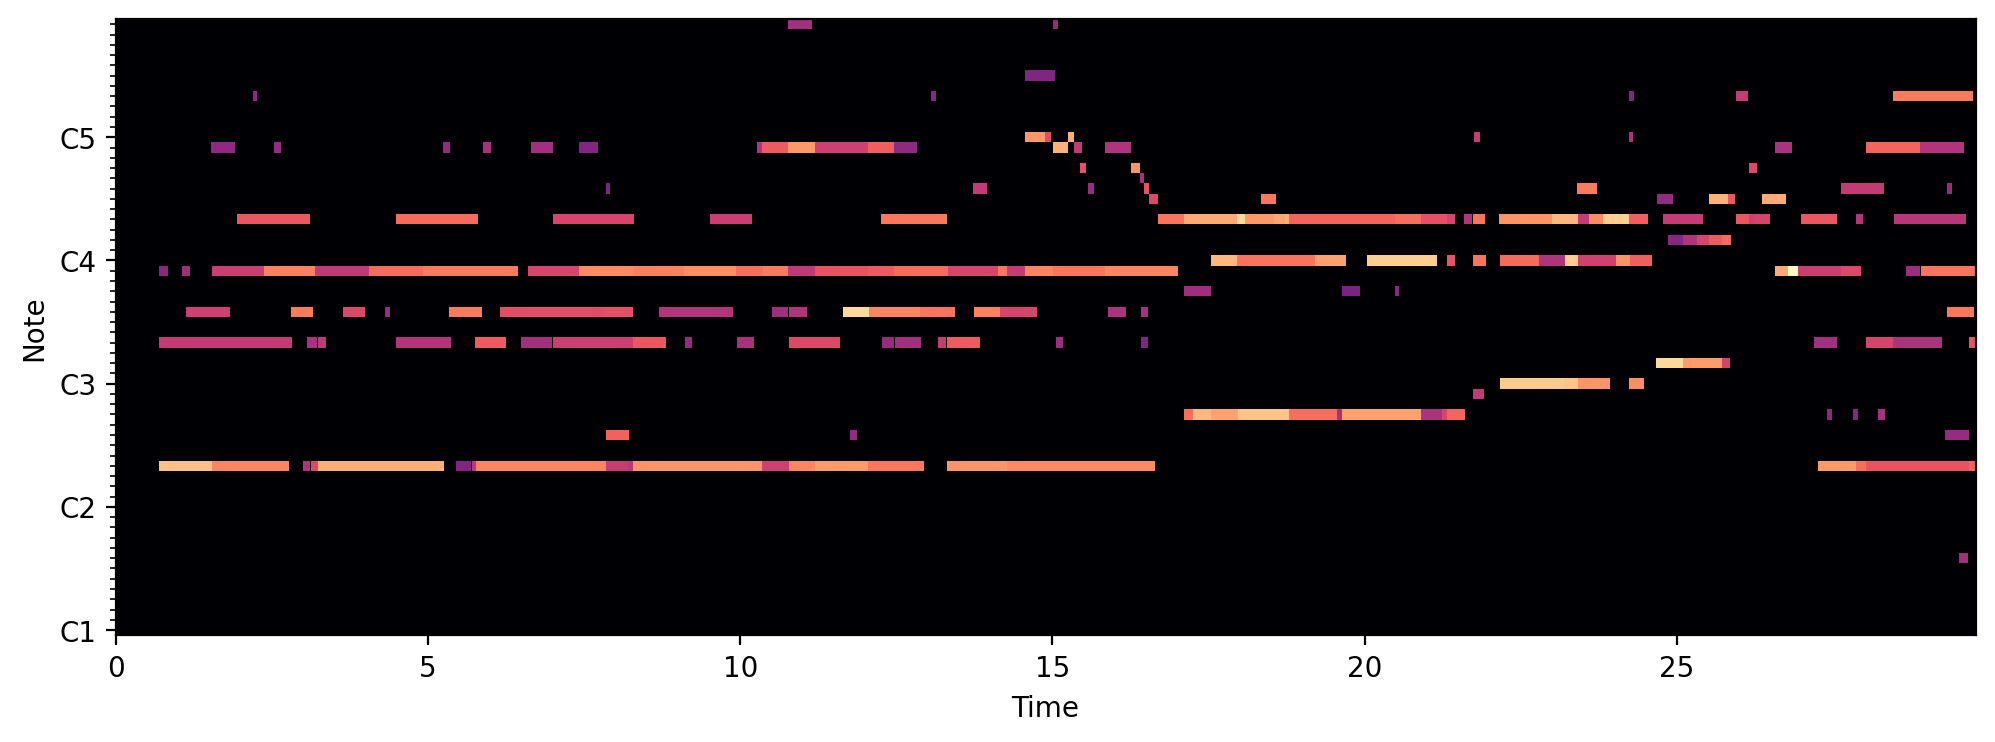

In [22]:
import matplotlib.pyplot as plt
import librosa
import pretty_midi
import librosa.display

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [15]:
import IPython
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)

# Tayuya midi to guitar tabs

In [24]:
from tayuya import MIDIParser
mid = MIDIParser('results/basic_pitch/metallica_30s_basic_pitch.mid', track=1)
print(mid.render_tabs())
mid.get_tracks()

E-----------------------------------------------12--12-----------------
A-----------------------12---------------12-------------------12--12---
D--------------------------------------------9-------------------------
G-------9--9--9------9------------9---------------------9--9-----------
B-7--7-----------10---------7--7-----10-------------------------------7
E----------------------------------------------------------------------

E----------------------------------------------------------------------
A----------------------------------------------------------------------
D---------------9------------------------------------------------------
G----------------------------9--9-------------------------9--9---------
B--10--7--7--7-----7--7--10--------7--7--7--7--7--10--10--------10--10-
E----------------------------------------------------------------------

E----------------------------------------------------------------------
A-------------12---------12------------------------------12--1

{0: '', 1: ''}